<a href="https://colab.research.google.com/github/eebjwa/SENSE_GEE_TEAM3/blob/main/timeseries.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [122]:
# Set up session
import ee
ee.Authenticate()
ee.Initialize()

To authorize access needed by Earth Engine, open the following URL in a web browser and follow the instructions. If the web browser does not start automatically, please manually browse the URL below.

    https://accounts.google.com/o/oauth2/auth?client_id=517222506229-vsmmajv00ul0bs7p89v5m89qs8eb9359.apps.googleusercontent.com&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fearthengine+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdevstorage.full_control&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&response_type=code&code_challenge=Xu9l7-N7_EkExc4JSpVcnyJ95_lmpGzGFPPAQrnf3jk&code_challenge_method=S256

The authorization workflow will generate a code, which you should paste in the box below. 
Enter verification code: 4/1AfDhmriDNDG5v4jxf3sWFMdjr-kMr425FECdN9allrkubH8BgB2VBGpj33I

Successfully saved authorization token.


Open some dataset in Hispaniola


In [123]:
zoomed_out =  ee.Geometry.Polygon(
        [[[-74.60668900677238, 20.088333497505946],
          [-74.60668900677238, 17.687361057873034],
          [-68.11376908489738, 17.687361057873034],
          [-68.11376908489738, 20.088333497505946]]])
zoomed_in =  ee.Geometry.Polygon(
        [[[-71.7976970344606, 19.335441167371748],
          [-71.7976970344606, 19.19316176101097],
          [-71.60268971024185, 19.19316176101097],
          [-71.60268971024185, 19.335441167371748]]])

collection = ee.ImageCollection('MODIS/006/MOD44B').filterDate('2000-01-01', '2019-12-31').sort('system:time_start', False)#.filterBounds(zoomed_out).filterDate('2000-01-01', '2019-12-31').sort('system:time_start', False)
veg2019 = collection.filterDate('2019-01-01', '2019-12-31').first()
veg2018 = collection.filterDate('2018-01-01', '2018-12-31').first()
veg2000 = collection.filterDate('2000-01-01', '2000-12-31').first()

Put all of these on a map (reference)


In [ ]:
import folium
!pip install geehydro
import geehydro

In [125]:
# Use folium to visualize the imagery.
map = folium.Map(location = [18.999768, -71.374124], zoom_start=8)
map.addLayer(veg2000, {'gain':2},'2000')
map.addLayer(veg2019, {'gain':2}, '2019')
map.addLayer(veg2018, {'gain':2},'2018')
folium.LayerControl().add_to(map)
map

Plot cumulative differences in vegetation(ignore this bit because I abandoned the idea)




In [106]:
collectionNonVeg = collection.filterDate('2000-01-01', '2019-12-31').sort('system:time_start', False).select('Percent_NonVegetated')

Check that collection still contains data (ignore this bit because I abandoned the idea)



In [ ]:
map = folium.Map(location = [18.999768, -71.374124], zoom_start=8)
map.addLayer(collectionNonVeg.first(), {'gain':2},'nonVeg')
folium.LayerControl().add_to(map)
map

In [ ]:
mean = collectionNonVeg.mean()

def subtracting(image):
  return image.subtract(mean).set('system:time_start', image.get('system:time_start'))

series = collectionNonVeg.map(subtracting)
series_sum = series.sum()

map = folium.Map(location = [18.999768, -71.374124], zoom_start=8)
map.addLayer(series_sum, {'gain':2},'Cumulative difference in non-vegetation')
folium.LayerControl().add_to(map)
map

TIME SERIES (and it works!)

In [249]:
%matplotlib inline
from IPython.display import Image
import ee, datetime
import pandas as pd
from pylab import *
from matplotlib.pylab import rcParams

# List of used image bands
band_list = ['Percent_Tree_Cover', 'Percent_NonTree_Vegetation', 'Percent_NonVegetated']

collection = ee.ImageCollection('MODIS/006/MOD44B').select(band_list)#.filterBounds(point)#.filterBounds(zoomed_out).filterDate('2000-01-01', '2019-12-31').sort('system:time_start', False)

count = collection.size()
print('Number of images in collection: ', str(count.getInfo())+'\n')

# Get info from the point
info = collection.getRegion(geometry=zoomed_out, scale=20000).getInfo()    #.filterBounds(zoomed_out).getInfo() # change colelction by series

print(info)

# Reshape image collection 
# Spearate header from data, and store data in an array
header = info[0]
data = array(info[1:])

# Extract time from data
iTime = header.index('time')
time = [datetime.datetime.fromtimestamp(i/1000) for i in (data[0:,iTime].astype(int))]

iBands = [header.index(b) for b in band_list]
yData = data[0:,iBands].astype(np.float)
print(yData)

trees = yData[:,0]

# Reshape tree array into Pandas Dataframe
dfTC = pd.DataFrame(data=trees, columns=['Percent_Tree_Cover'])

dfTC['time'] = pd.Series(time, index=dfTC.index)

# get mean value for every year
groupTC =dfTC.groupby(['time']).mean()

# Do same for non-tree vegetation
dfNT = pd.DataFrame(data=trees, columns=['Percent_NonTree_Vegetation'])
dfNT['time'] = pd.Series(time, index=dfNT.index)
groupNT =dfNT.groupby(['time']).mean()

# Do same for non-vegetated
dfNV = pd.DataFrame(data=trees, columns=['Percent_NonVegetated'])
dfNV['time'] = pd.Series(time, index=dfNV.index)
groupNV =dfNV.groupby(['time']).mean()


#print(df['time'])
print(groupTC['Percent_Tree_Cover'])

Number of images in collection:  20

[['id', 'longitude', 'latitude', 'time', 'Percent_Tree_Cover', 'Percent_NonTree_Vegetation', 'Percent_NonVegetated'], ['2000_03_05', -74.47033705350833, 17.696811097154573, 952214400000, None, None, None], ['2001_03_06', -74.47033705350833, 17.696811097154573, 983836800000, None, None, None], ['2002_03_06', -74.47033705350833, 17.696811097154573, 1015372800000, None, None, None], ['2003_03_06', -74.47033705350833, 17.696811097154573, 1046908800000, None, None, None], ['2004_03_05', -74.47033705350833, 17.696811097154573, 1078444800000, None, None, None], ['2005_03_06', -74.47033705350833, 17.696811097154573, 1110067200000, None, None, None], ['2006_03_06', -74.47033705350833, 17.696811097154573, 1141603200000, None, None, None], ['2007_03_06', -74.47033705350833, 17.696811097154573, 1173139200000, None, None, None], ['2008_03_05', -74.47033705350833, 17.696811097154573, 1204675200000, None, None, None], ['2009_03_06', -74.47033705350833, 17.69681109

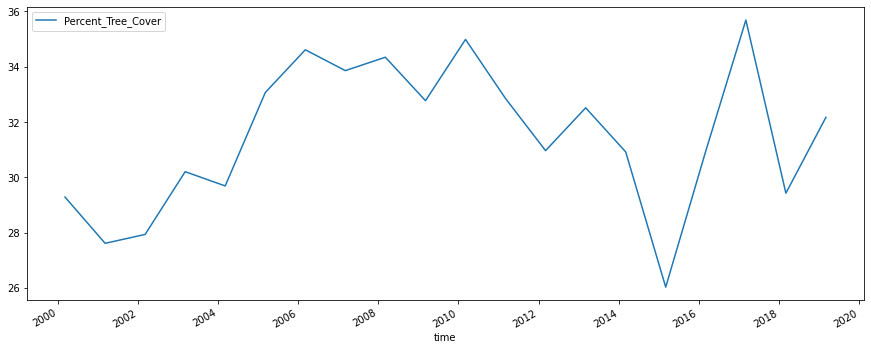

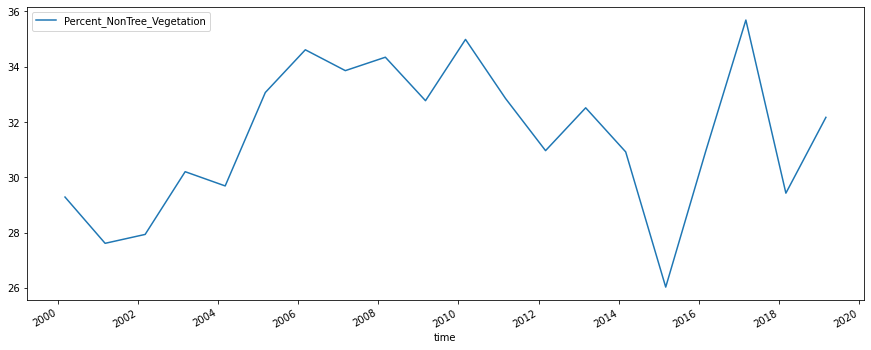

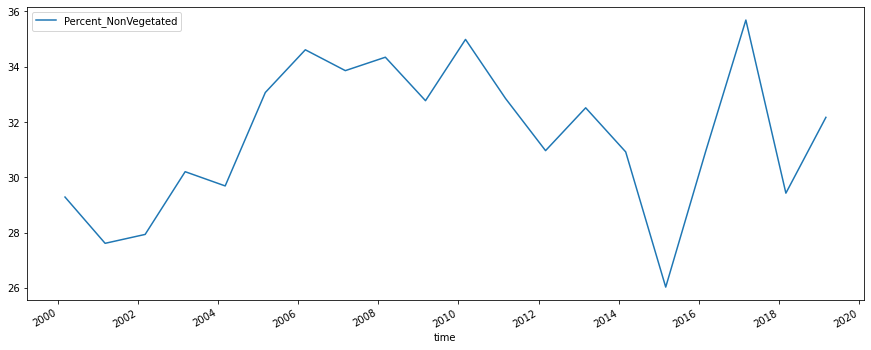

In [248]:
# Plotting

rcParams['figure.figsize'] = 15, 6
groupTC.plot()
groupNT.plot()
groupNV.plot()
plt.show()
